In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline

accuracy = pd.read_csv("./Accuracy Revised.csv")

EDA

In [39]:
accuracy.head()

,Date,QBO,QBSE,Mint
0,1-Jan-18,0.541773,0.562901,NaN
1,2-Jan-18,0.555210,0.615290,NaN
2,3-Jan-18,0.559857,0.646905,NaN
3,4-Jan-18,0.545718,0.557536,NaN
4,5-Jan-18,0.539705,0.568850,NaN


In [40]:
accuracy.describe()

,QBO,QBSE,Mint
count,478.000000,476.000000,306.000000
mean,0.634876,0.630418,0.971331
std,0.085931,0.099211,0.008695
min,0.363974,0.318323,0.954104
25%,0.565354,0.615173,0.964081
50%,0.644821,0.669324,0.968719
75%,0.709912,0.682226,0.979515
max,0.776034,0.772107,0.993386


In [41]:
accuracy.dtypes

Date     object
QBO     float64
QBSE    float64
Mint    float64
dtype: object

In [42]:
accuracy.shape

(479, 4)

In [43]:
accuracy['Date'] = pd.to_datetime(accuracy.Date)

In [44]:
accuracy = accuracy.set_index('Date')

In [45]:
accuracy.head()

,QBO,QBSE,Mint
Date,,,
2018-01-01,0.541773,0.562901,NaN
2018-01-02,0.555210,0.615290,NaN
2018-01-03,0.559857,0.646905,NaN
2018-01-04,0.545718,0.557536,NaN
2018-01-05,0.539705,0.568850,NaN


Plot the 3 model performance metrics

Text(0, 0.5, 'Accuracy')

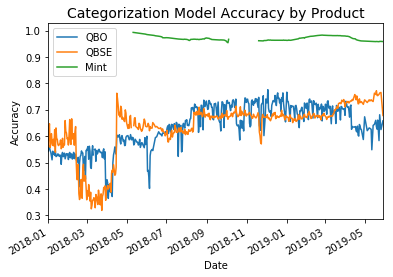

In [46]:
accuracy.plot()
plt.title("Categorization Model Accuracy by Product", fontsize = 14)
plt.ylabel("Accuracy")

In [47]:
#check null values by time series
accuracy.isna().sum()

QBO       1
QBSE      3
Mint    173
dtype: int64

In [48]:
#replace na with mean
accuracy = accuracy.fillna(accuracy.mean())

In [49]:
accuracy['QBO'].dropna()

Date
2018-01-01    0.541773
2018-01-02    0.555210
2018-01-03    0.559857
2018-01-04    0.545718
2018-01-05    0.539705
2018-01-06    0.525304
2018-01-07    0.510068
2018-01-08    0.542908
2018-01-09    0.532132
2018-01-10    0.536886
2018-01-11    0.526818
2018-01-12    0.544467
2018-01-13    0.522622
2018-01-14    0.523546
2018-01-15    0.528135
2018-01-16    0.532839
2018-01-17    0.527210
2018-01-18    0.523479
2018-01-19    0.528859
2018-01-20    0.524227
2018-01-21    0.493101
2018-01-22    0.530010
2018-01-23    0.538138
2018-01-24    0.522137
2018-01-25    0.524462
2018-01-26    0.535445
2018-01-27    0.513988
2018-01-28    0.523045
2018-01-29    0.533567
2018-01-30    0.529821
                ...   
2019-04-12    0.634424
2019-04-15    0.634794
2019-04-16    0.636309
2019-04-17    0.620036
2019-04-18    0.616357
2019-04-19    0.638045
2019-04-20    0.603663
2019-04-21    0.600219
2019-04-22    0.644146
2019-04-23    0.638476
2019-04-24    0.626502
2019-04-25    0.625206
2019-0

In [77]:
accuracy['QBO'].head()

Date
2018-01-01    0.541773
2018-01-02    0.555210
2018-01-03    0.559857
2018-01-04    0.545718
2018-01-05    0.539705
Name: QBO, dtype: float64

In [51]:
#take first difference of the QBO time series
diff = accuracy['QBO'].diff(periods = 1)

In [52]:
diff.head()

Date
2018-01-01         NaN
2018-01-02    0.013437
2018-01-03    0.004646
2018-01-04   -0.014138
2018-01-05   -0.006013
Name: QBO, dtype: float64

In [53]:
type(diff)

pandas.core.series.Series

In [54]:
#replace na with mean
diff = diff.fillna(diff.mean())

In [55]:
diff.isna().sum()

0

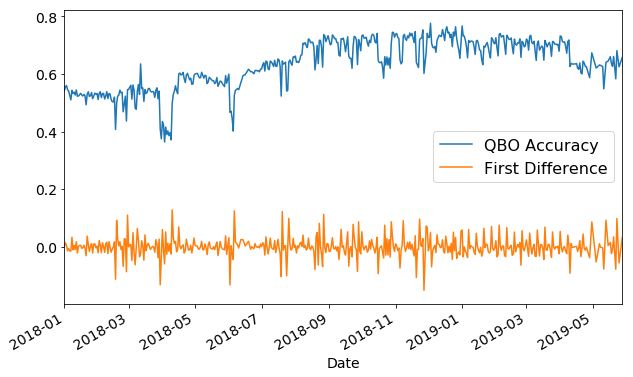

In [56]:
plt.figure(figsize=(10,6))
accuracy['QBO'].plot(legend = True, fontsize=14)
diff.plot(legend = True, fontsize=14)
plt.legend(['QBO Accuracy', 'First Difference'], fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.show()

In [57]:
type(accuracy)

pandas.core.frame.DataFrame

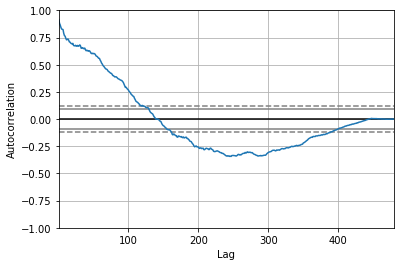

In [58]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(accuracy.QBO)
plt.show()

#plot the ACF of the original QBO time series

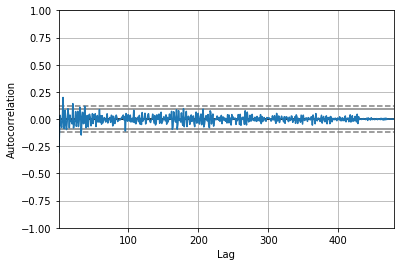

In [59]:
autocorrelation_plot(diff)
plt.show()

#plot the ACF of the first difference of the time series

In [81]:
import pandas as pd
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

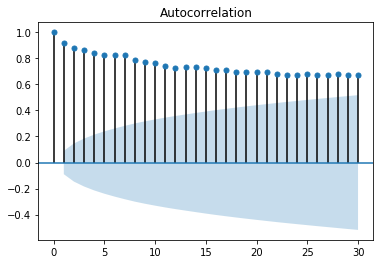

In [63]:
plot_acf(accuracy.QBO.values, lags=30)
plt.show()

#plot the ACF of the QBO time series in a different way

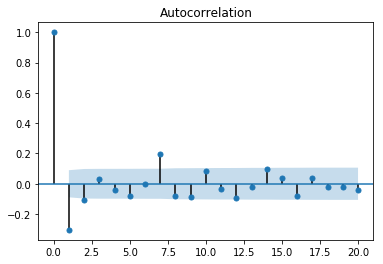

In [64]:
plot_acf(diff, lags = 20)
plt.show()

#plot the ACF of the first difference of the QBO time series in a different way

In [65]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    '''time-series function to plot rolling statistics (mean and std) and perform Dickey-Fuller test'''
    
    # Determining rolling statistics:
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plotting rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Performing the Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

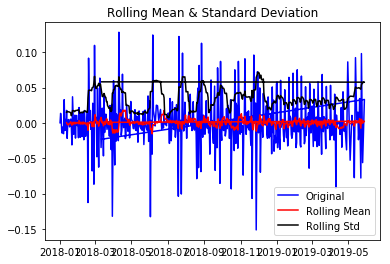

Results of Dickey-Fuller Test:
Test Statistic                -8.440649e+00
p-value                        1.767018e-13
#Lags Used                     1.200000e+01
Number of Observations Used    4.660000e+02
Critical Value (1%)           -3.444461e+00
Critical Value (5%)           -2.867762e+00
Critical Value (10%)          -2.570084e+00
dtype: float64


In [66]:
test_stationarity(diff)

#test stationarity of the first difference. we reject the null hypothesis the time series is non-stationary at 1% significance level

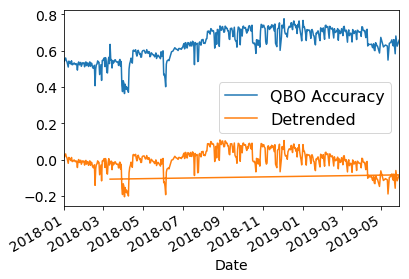

In [67]:
import scipy.signal
detrended_QBO = scipy.signal.detrend(accuracy.QBO.values)

accuracy['QBO'].plot(legend = True, fontsize=14)
plt.plot(accuracy.index, detrended_QBO)
plt.legend(['QBO Accuracy', 'Detrended'], fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.show()

#plot the detrended QBO time series and the original time series


In [68]:
type(accuracy.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [69]:
type(detrended_QBO)

numpy.ndarray

In [73]:
import pandas as pd
detrended_QBO = pd.Series(detrended_QBO, index = accuracy.index)

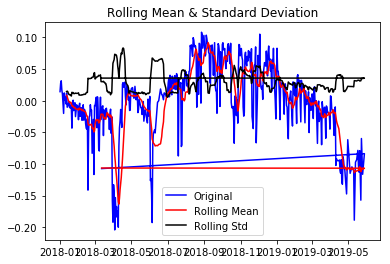

Results of Dickey-Fuller Test:
Test Statistic                  -2.069970
p-value                          0.256760
#Lags Used                      13.000000
Number of Observations Used    465.000000
Critical Value (1%)             -3.444491
Critical Value (5%)             -2.867776
Critical Value (10%)            -2.570091
dtype: float64


In [74]:
test_stationarity(detrended_QBO)
#test stationarity of the detrended QBO time series. We cannot reject the hypothesis the time series is non-stationary

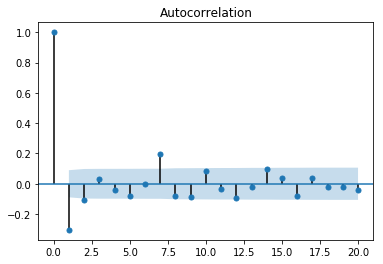

In [80]:
plot_acf(diff, lags = 20)
plt.show()
#ACF cuts off after lag 1

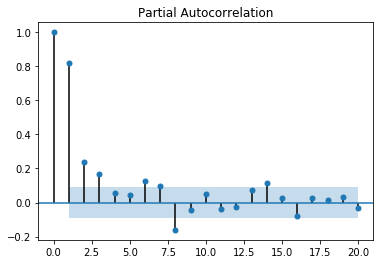

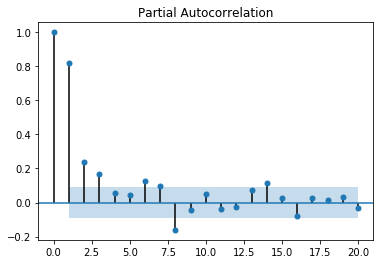

In [82]:
plot_pacf(detrended_QBO, lags = 20)
#PACF tails off

In [89]:
#fit an ARIMA model
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(accuracy.QBO, order = (0,1,1))

C:\Users\yzhou4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\yzhou4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.QBO   No. Observations:                  478
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 957.517
Method:                       css-mle   S.D. of innovations              0.033
Date:                Tue, 11 Jun 2019   AIC                          -1909.033
Time:                        22:23:09   BIC                          -1896.524
Sample:                             1   HQIC                         -1904.115
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0002      0.001      0.254      0.799      -0.001       0.002
ma.L1.D.QBO    -0.4809      0.049     -9.849      0.000      -0.577      -0.385
                                    Roots       

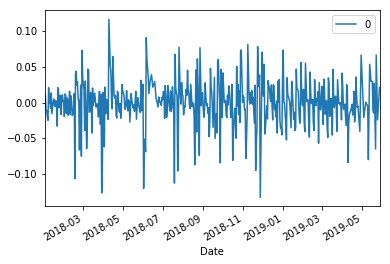

In [96]:
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
print(residuals.describe())